# Model 1 - Recurrent neural network (RNN) using only the kinematic features.

In [619]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('./src')
from data_utils import *
clear_output(wait=False)

### Load train, validation and test data

In [327]:
user_train, user_val, user_test = train, val, test = train_test_data_split()

In [328]:
data_train = pd.concat([create_data_frame(*load_user_data(user), segmentation=True) for user in user_train]).reset_index(drop=True)
data_val = pd.concat([create_data_frame(*load_user_data(user), segmentation=True) for user in user_val]).reset_index(drop=True)
data_test = pd.concat([create_data_frame(*load_user_data(user), segmentation=True) for user in user_test]).reset_index(drop=True)

#### Example input data

In [ ]:
data_train[data_train['segment_point_count'] >= 5].head(5)

#### Numer of training data points

In [330]:
len(data_train[data_train['segment_point_count'] >= 5])

1181496

In [331]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [485]:
def create_dataset(df):
    seq = np.stack([np.roll(df[['delta_d', 'bearing']].values, i, axis = 0) for i in range(6)], axis = 1)
    seq = seq[df['segment_ix'] >= 5]
    
    #tod = np.stack([np.roll(df['ts'].dt.hour.values, i, axis = 0) for i in range(6)], axis = 1)    
    tod = df.loc[df['segment_ix'] >= 5, 'tod'].values
    tod_one_hot = np.eye(6)[tod]    
    
    #target = np.stack([np.roll(df['label'].values, i, axis = 0) for i in range(6)], axis = 1)
    target = df.loc[df['segment_ix'] >= 5, 'label'].values
    
    return torch.utils.data.TensorDataset(torch.Tensor(seq), torch.Tensor(tod_one_hot), torch.LongTensor(target))

## Example Input/output data from ``TensorDataset``

In [486]:
demo_dataset = create_dataset(data_train.head(100))

X_seq, X_tod, y = demo_dataset.tensors

print('X_seq :', X_seq[[0,12,29]])
print('X_tod :', X_tod[[0,12,29]])
print('y :', y[[0,12,29]])

X_seq : tensor([[[ 1.1209e-01,  2.0860e+00],
         [ 3.5233e-01, -6.7493e-01],
         [ 2.4643e-01,  2.6194e+00],
         [ 2.4643e-01, -5.2224e-01],
         [ 3.8497e+02,  1.3868e+00],
         [ 3.8494e+02, -1.7548e+00]],

        [[ 1.2129e+01,  2.7726e+00],
         [ 1.2129e+01, -3.6900e-01],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 1.3038e+01,  2.7710e+00]],

        [[ 2.0455e+01,  1.4131e+00],
         [ 1.2782e-02, -2.0330e+00],
         [ 1.1136e-02,  1.6217e+00],
         [ 1.1136e-02, -1.5199e+00],
         [ 2.3139e-02,  1.3471e+00],
         [ 4.6278e-02, -1.7945e+00]]])
X_tod : tensor([[0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.]])
y : tensor([1, 1, 1])


In [487]:
X_tod[[0,6,12]].shape

torch.Size([3, 6])

### Hyper Parameters

In [586]:
SEQ_LENGTH = 6
SEQ_FEATURES = 2
TOD_INPUT_DIM = 24
RNN_HIDDEN_DIM = 4
NUM_EPOCH = 10
NUM_CLASSES = 2

LEARNING_RATE = 0.1
LEARNING_DECAY_FACTOR = 0.1
LEARNING_DECAY_EPOCHS = [6,8]

#### Define Data Loaders

In [589]:
train_dataloader = torch.utils.data.DataLoader(create_dataset(data_train), batch_size=1000, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(create_dataset(data_val), batch_size=1000, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(create_dataset(data_test), batch_size=1000, shuffle=True)

#### How many data points are lost due to building sequences?

In [583]:
print(f'{1 - len(create_dataset(data_train)) / len(data_train):.2%}')

1.38%


In [628]:
def adjust_lr(optimizer, epoch):
    number_decay_points_passed = np.sum(epoch >= np.array(LEARNING_DECAY_EPOCHS))
    lr = LEARNING_RATE * (LEARNING_DECAY_FACTOR ** k)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [629]:
class RnnNet(nn.Module):

    def __init__(self, seq_length, seq_features, hidden_dim, input_tod_dim = 6, output_dim = 2, n_layers = 1, bidirectional=True):
        super(RnnNet, self).__init__()
        self.seq_length = seq_length
        self.seq_features = seq_features
        self.input_tod_dim = input_tod_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        drop_prob=0.45
        rnn_output_dim = 2*seq_length*hidden_dim if bidirectional else seq_length*hidden_dim 
        hfc = 256 * 2
        hfc8 = hfc // 5
        
        self.DO = nn.Dropout(drop_prob)    
        
        self.BNgru_0_K = nn.BatchNorm1d(seq_length)
        self.rnn_1_1 = nn.GRU(2, hidden_dim, n_layers, batch_first=True
                         , bidirectional=bidirectional
                        )
        self.BNgru_1_1 = nn.BatchNorm1d(seq_length)
                            
        self.fc_out_1 = nn.Linear(rnn_output_dim + input_tod_dim, hfc)
        
        self.BNFC_hfc_out_1 = nn.BatchNorm1d(hfc)
        
        self.fc_out_2 = nn.Linear(hfc, hfc8)
        
        self.BNFC_hfc_out_2 = nn.BatchNorm1d(hfc8)
        
        
        self.l_out = nn.Linear(in_features=hfc8,
                            out_features=output_dim,
                            bias=False)

    def forward(self, x_seq, x_tod):
        features = []
        """        
        out = {}
        x_fuse = torch.cat([x_dist.unsqueeze(1),x_br.unsqueeze(1)],dim=1)
        x_fuse=self.BNgru_0_K(x_fuse)
        
        x_fuse = x_fuse.unsqueeze(2)
        #print('7',x_fuse.shape)
        x_fuse = x_fuse.reshape(sequence_size, -1, x_fuse.shape[1])
        #print('8',x_fuse.shape)
        
        #input of shape (seq_len, batch, input_size)
        x_fuse, h_img = self.rnn_1_1(x_fuse)
        #print('9',x_fuse.shape)
        
        x_fuse = x_fuse.reshape(int(x_fuse.shape[1]*x_fuse.shape[0]), -1)
        #print('10',x_fuse.shape)
        
        x_fuse = self.DO(self.BNgru_1_1(relu(x_fuse)))
        #print('11',x_fuse.shape)
        
        features.append(x_fuse)
        
        #>>>>> x_dTS <<<<<#
        #print('ToD******** 1 ',x_dTS.shape)
        x_dTS = self.BNgru_0_TS(x_dTS)       
        #print('ToD******** 2 ',x_dTS.shape)
        features.append(x_dTS)
        
        ## Output layer where all features are in use ##
        #print('12',features[0].shape, features[1].shape)
        features_final = torch.cat(features, dim=1)
        #print('13',features_final.shape)
        features_final = self.BNFC_hfc_out_0(features_final)
        #print('14',features_final.shape)
        features_final = self.DO(self.BNFC_hfc_out_1(relu(self.fc_out_1(features_final))))
        #print('15',features_final.shape)
        features_final = self.DO(self.BNFC_hfc_out_2(relu(self.fc_out_2(features_final))))
        #print('16',features_final.shape)
        #out = log_softmax(self.l_out(features_final), dim=1) 
        out = softmax(self.l_out(features_final), dim=1) 
        #print('17',self.l_out(features_final).shape)
        return out
        """        
        
        # x_seq #
        x_seq = self.BNgru_0_K(x_seq)   
        
        # x_seq : (batch, seq_lenth, seq_features)                              
        x_seq = x_seq.permute(1, 0, 2)        
        # x_seq : (seq_lenth, batch, seq_features)
                
        x_seq, h_n = self.rnn_1_1(x_seq)
        # x_seq : (seq_len, batch, num_directions * hidden_size):
        # h_n : (num_layers * num_directions, batch, hidden_size)

        x_seq = x_seq.permute(1, 0, 2)
        # x_seq : (batch, seq_lenth, num_directions * hidden_size)
        
        x_seq = F.relu(x_seq)
        x_seq = self.BNgru_1_1(x_seq)
               
        x_seq = self.DO(x_seq)
        
        features.append(x_seq)
        
        # x_tod #
        x_tod = x_tod.unsqueeze(2)
        features.append(x_tod)
        
        ## Output layer where all features are in use ##
        
        features_final = torch.cat(features, dim=2)
        features_final = features_final.contiguous().view(features_final.shape[0], -1)
        
        #features_final = self.BNFC_hfc_out_0(features_final)
        
        features_final = self.DO(self.BNFC_hfc_out_1(F.relu(self.fc_out_1(features_final))))
        
        features_final = self.DO(self.BNFC_hfc_out_2(F.relu(self.fc_out_2(features_final))))
        
        out = self.l_out(features_final)
        #out = out.view(features_final.shape[0], self.seq_length, self.output_dim)        
        out = F.softmax(out, dim=1) 
        
        
        return out

#### Define class weights due to large class im-balance

In [630]:
class_weights = [(data_train['label'] == 0).sum()/(data_train['label'] == x).sum() for x in range(NUM_CLASSES)]
class_weights

[1.0, 0.36125205657481785]

#### Define model, optimizer and loss

In [631]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = RnnNet(SEQ_LENGTH, SEQ_FEATURES, RNN_HIDDEN_DIM, bidirectional=False).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(weight = torch.Tensor(class_weights).to(device))

#### Number of parameters

In [632]:
np.sum([np.product(x.cpu().detach().numpy().shape) for x in model.parameters()])

69750

#### Test input/output of model

In [633]:
out = model(X_seq.to(device), X_tod.to(device))
print(out.shape)

torch.Size([495, 2])


In [634]:
out[:2].cpu()

tensor([[9.9973e-01, 2.6623e-04],
        [5.3393e-01, 4.6607e-01]], grad_fn=<CopyBackwards>)

In [635]:
phases = {
    'train': {
        'dataloader': train_dataloader,
        'is_training': True,
    },
    'validation': {
        'dataloader': val_dataloader,
        'is_training': False,
    },
    'test': {
        'dataloader': test_dataloader,
        'is_training': False,
    }
}

### Train / Validation loop

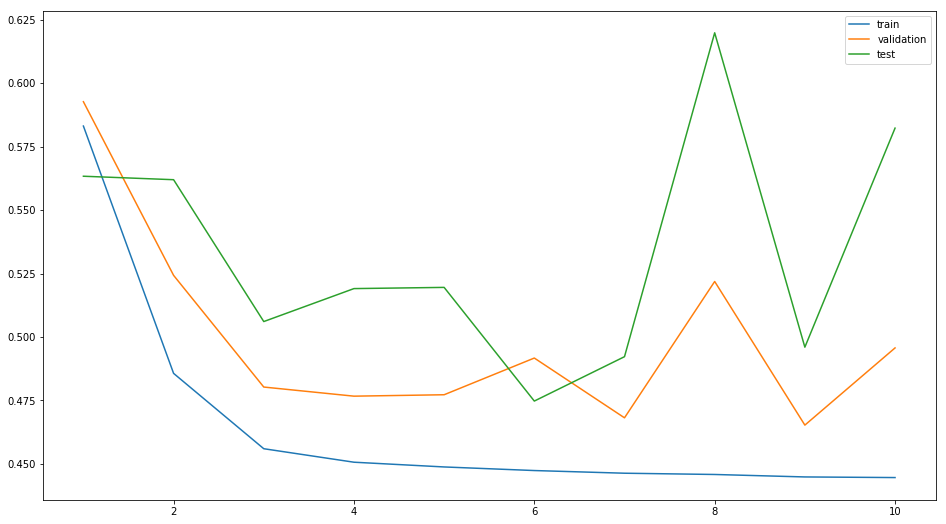

In [636]:
for epoch in range(1, NUM_EPOCH + 1):
    
    for phase_name, phase in phases.items():
        epoach_loss = 0.0
                
        phase_is_training = phase['is_training']
        phase_dataloader = phase['dataloader']
        model.train(phase_is_training)
        
        # Ajust and save the learning rate in the phase dict
        if phase_is_training:
            lr = adjust_lr(optimizer, epoch)
            phase.setdefault('lr', []).append(lr)
            
        # Iterate over each bath in the phase
        for i, batch in enumerate(phase_dataloader, 1):
            X_seq, X_tod, y = batch

            X_seq = X_seq.to(device)
            X_tod = X_tod.to(device)
            y = y.to(device)

            with torch.set_grad_enabled(phase_is_training):
                out = model(X_seq, X_tod)
                loss = criterion(out, y)

            if phase_is_training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
            epoach_loss += loss.item()
        
        # Save the loss for the epoch in the phase dict
        phase.setdefault('loss', []).append(epoach_loss/i)
        
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize = (16, 9))
    #ax.set_yscale('log')
    
    for phase_name, phase in phases.items():
        ax.plot(np.arange(1, epoch + 1), phase['loss'], label = phase_name)        
    
    ax.legend()
    plt.show();            

### Validation/Test prediction loop

In [637]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    phase_dataloader = phase['dataloader']
    phase['predicted'] = []
    phase['true'] = []
    
    for i, batch in enumerate(phase_dataloader, 1):
        X_seq, X_tod, y = batch

        X_seq = X_seq.to(device)
        X_tod = X_tod.to(device)
        y = y.to(device)
        
        with torch.no_grad():
            out = model(X_seq, X_tod)
            probability, predicted = torch.max(out, 1)
            correct = (predicted == y).cpu().numpy()
            
        phase['predicted'].extend(list(predicted.cpu().numpy()))
        phase['true'].extend(list(y.cpu().numpy()))

### Final results

In [638]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    print(phase_name)
    print(classification_report(phase['true'], phase['predicted'], target_names = ['Motion','Stop']))

validation
              precision    recall  f1-score   support

      Motion       0.57      0.95      0.71     43324
        Stop       0.95      0.57      0.71     72617

   micro avg       0.71      0.71      0.71    115941
   macro avg       0.76      0.76      0.71    115941
weighted avg       0.81      0.71      0.71    115941

test
              precision    recall  f1-score   support

      Motion       0.37      0.95      0.53     42471
        Stop       0.97      0.44      0.61    126024

   micro avg       0.57      0.57      0.57    168495
   macro avg       0.67      0.70      0.57    168495
weighted avg       0.81      0.57      0.59    168495

